# Animate Samples from a Gauss-Markov Posterior

We assume you've read the tutorial about animating a Gaussian distribution. This tutorial will explain how to use the `animate_with*` functionality in conjunction with the sampling routines in `ProbNum.filtsmooth` to animate a sample from a Gauss-Markov posterior.

In [1]:
from probnumeval import visual
import numpy as np
import matplotlib.pyplot as plt
import probnum as pn
np.random.seed(42)

Let us start by constructing a simple filtering problem.

In [2]:
locations = np.linspace(0, 2*np.pi, 100)
data = 0.5 * np.random.randn(100) + np.sin(locations)


We fit a once-integrated Brownian motion prior to this data.

In [3]:
prior = pn.statespace.IBM(1, 1)
measmod = pn.statespace.DiscreteLTIGaussian(state_trans_mat = np.eye(1, 2), shift_vec=np.zeros(1), proc_noise_cov_mat=0.25 * np.eye(1))
initrv = pn.random_variables.Normal(np.zeros(2), np.eye(2))

kalman = pn.filtsmooth.Kalman(prior, measmod, initrv)
posterior = kalman.filtsmooth(times=locations, dataset=data)

Let us start by visualizing this output

In [4]:
t = np.linspace(0, 2*np.pi, 200)
mean = (posterior(t).mean @ np.eye(2, 1)).squeeze()
std = np.sqrt(np.eye(1, 2) @ posterior(t).cov @ np.eye(2, 1)).squeeze()


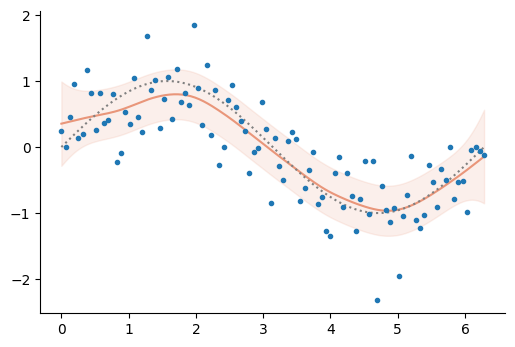

In [11]:
fig, ax = plt.subplots(dpi=100)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(t, mean, color="darksalmon")
ax.plot(t, np.sin(t), color="gray", linestyle="dotted")
ax.fill_between(t, mean - 3*std, mean + 3*std, alpha=0.15, color="darksalmon")
ax.plot(locations, data, marker=".", linestyle="None")
plt.show()

The true solution is captured well.

Next, we draw an animated samples on 12 frames from this posterior with the `animate_with_great_circle_of_unitsphere` function.
Since the posterior has a 2-dimensional image, we generate 15 samples on a 200-dimensional sphere and reshape to get an (12, 100, 2) array.

In [16]:
num_frames = 9

In [17]:
base_measure_samples = visual.animate_with_great_circle_of_unitsphere(200, num_frames=num_frames, endpoint=True).reshape(num_frames, 100, 2)
print(base_measure_samples.shape)

(9, 100, 2)


To circumvent the `posterior.sample()` function, which itself draws samples from a standard Normal base measure and transforms them according to the rules specified by the posterior, we can call the transformation directly on the spherical pseudo-samples. We visualise those 15 samples in a plot of images (top left to bottom right).

In [18]:
res = posterior.transform_base_measure_realizations(base_measure_samples, size=(num_frames,))

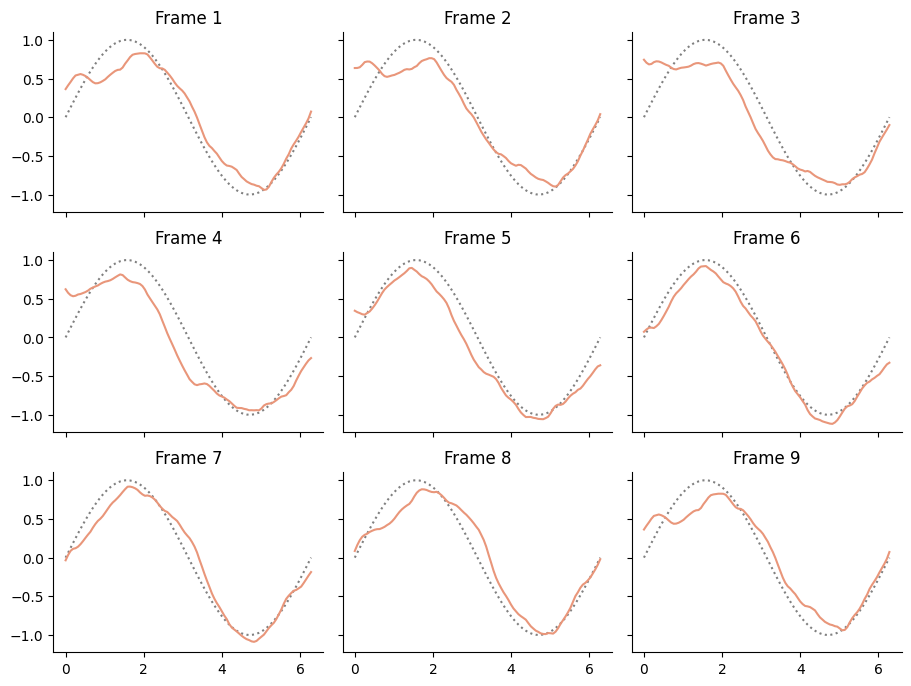

In [19]:
fig, axes = plt.subplots(dpi=100, ncols=3, nrows=num_frames // 3, sharey=True, sharex=True, figsize=(num_frames*1, num_frames*.75), constrained_layout=True)

for ax in axes.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
for idx, (ress, ax) in enumerate(zip(res, axes.flatten())):
    ax.plot(posterior.locations, np.sin(posterior.locations), color="gray", linestyle="dotted")
    ax.plot(posterior.locations, ress @ np.eye(2, 1), color="darksalmon")
    ax.set_title(f"Frame {idx + 1}")
plt.show()

The same functionality can be used to animate samples from an ODE solution. Note, however, that the base measure of a `KalmanODESolution` is the base measure of the underlying `KalmanPosterior`, which requires higher-dimensional base measure samples than one might think in the first place.